In [1]:
from mtdScope import scopeEmulator
import matplotlib.pyplot as plt
import numpy as np
import time
#from scipy.optimize import curve_fit
import ROOT as rt
#from jupyterthemes import jtplot


#jtplot.style()
        
#load the sample data to test
se1 = scopeEmulator()
#se1.loadData('./data/SecondRun/Jan07_205749_Run9.hdf5')
se1.loadData('./data/Run1.hdf5')
se1.sliceEvent()


Welcome to JupyROOT 6.18/04


# Baseline finder in CNN model

### problem description

The idea to find baseline is that finding a region where is no obvious signal presents and do a fitting to extract the background. But on hand, the standard for "no signal presented" can be a little bit tricky to be implemented. On the other hand, the region window may change from event-to-event which will makes the implementation more tricky. However, the baseline is crutial for the integration since a wrong baseline means shifted the integration by a constant.

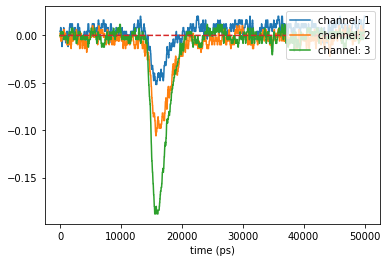

In [2]:
se1.showEvent(93,[1,2,3])
points = se1.getEventAdjusted(93)

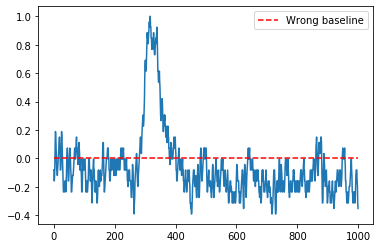

In [12]:
points = se1.getEventAdjusted(93)
bkg, data = se1.normalized_input(points[1])
plt.plot(data)
line = np.full(1000, 0)
plt.plot(line, '--',color='red',label='Wrong baseline')
plt.legend(loc='best')

### Why CNN?
For the event show above, the baseline is found by a simple program and it is obviously higher than its background, this will affect the integration significantly especially when the noise is large.

However, finding baseline is pretty easy for a human in sense by just a glance would be able to know the baseline information. Based on this idea, I trained a CNN model to find the baseline. The training samples are a random sampled Gaussian (as signal) + random sampled flat distribution (as true background). The achitecture of this model is show below:

In [4]:
se1.load_cnn_baseline_finder('baseline_finder_v2.h5')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 498, 4)            28        
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 249, 4)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 49, 2)             50        
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 24, 2)             0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 9, 1)              17        
_________________________________________________________________
flatten_8 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                

2020-01-13 21:40:56.525094: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-01-13 21:40:56.558344: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3193625000 Hz
2020-01-13 21:40:56.559301: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6c783a0 executing computations on platform Host. Devices:
2020-01-13 21:40:56.559345: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version


### The performace of the model
With this trained model above, I'd be able to correct the baseline easily. The first figure below shows the ML corrected baseline for the event above. And the second plot is the overlay between the with and without baseline corrected signals, you can see the CNN model works well.

baseline: [[-0.17712274]]


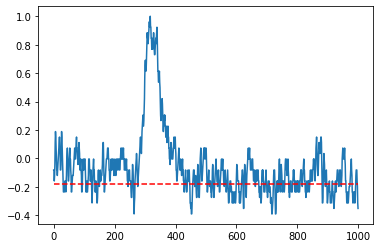

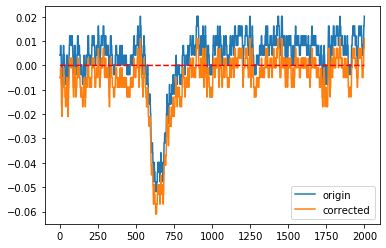

In [14]:
base = se1.baseline_finder.predict(data.reshape(1,1000,1))
line = np.full(1000, base)
plt.plot(data)
plt.plot(line, '--',color='red')
print('baseline:',base)
plt.show()
n=93
chan = 1
points = se1.getEventAdjusted(n)
points2 = se1.getEventAdjusted(n)
se1.cnn_baseline_correction(points,[1,2,3])
line = np.full(se1.nsamples,0)

plt.plot(points2[chan],label='origin')
plt.plot(points[chan],label='corrected')
plt.plot(line, '--',color='red')
plt.legend(loc='lower right')
plt.show()

### The performace over all the 500 sample data
This data is got from Jongho which contained 500 events, the statistics isn't high but enough to see something interesting. 

In this case, I processed the 500 events in two ways: 
1. SetA made by the simple programer to find the baseline. This set can be benchmark for testing the ML model.
2. SetB made by using the ML baseline correction

For these two sets, I applied the same trigger condition and integrated over the channel 2 to check the distribution difference between these two methods. 

In [21]:
se1 = scopeEmulator()
se1.loadData('./data/SecondRun/Jan07_205749_Run9.hdf5')
se1.sliceEvent()
se1.load_cnn_baseline_finder('baseline_finder_v2.h5')
charge1 = se1.charge_convertion(0,se1.nevent, 2, 0.04, [2],1)
charge0 = se1.charge_convertion(0,se1.nevent, 2, 0.04, [2],0)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 498, 4)            28        
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 249, 4)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 49, 2)             50        
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 24, 2)             0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 9, 1)              17        
_________________________________________________________________
flatten_8 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                

This plots below shows the overlay of the distribtions of the integration from the two methods described above. One can easily see that the blue one (with the correction) have significant shape difference from the orange one (no correction). And the baseline corrected one are more close to a Landau distribution! The following plots just show the Landu fitting results.

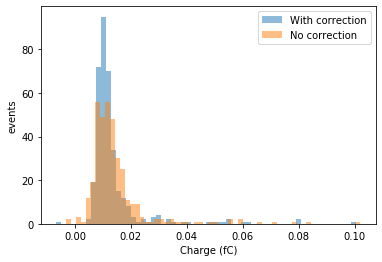

In [26]:
charges1 = np.multiply(charge1[1],-1.0/44000)
charges0 = np.multiply(charge0[1],-1.0/44000)
plt.hist(charges1,bins=60,alpha=0.5, label='With correction')
plt.hist(charges0,bins=60,alpha=0.5, label='No correction')
plt.legend(loc='best')
plt.xlabel('Charge (fC)')
plt.ylabel('events')
plt.show()

In [27]:

charges = np.multiply(charge1[1],-1.0/44000)
hchg = rt.TH1F("hchg0", "", 100, 0, .08)
for i in range(len(charges)):
    hchg.Fill(charges[i])
hchg.Scale(1.0/hchg.Integral())
canvas = rt.TCanvas("c", "", 500, 500)
flandau = rt.TF1("flandau", "[0]*TMath::Landau(x,[1],[2])", 0,0.08)
#bins = range(0, 0.08, 0.01)
#plt.plot(bin_edges[:-1], hist)
#plt.hist(charges, bins = 80)

#plt.xlabel("fC")


Warning in <TROOT::Append>: Replacing existing TH1: hchg0 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


 FCN=42.2858 FROM MIGRAD    STATUS=CONVERGED     170 CALLS         171 TOTAL
                     EDM=5.02644e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.01803e-01   6.54846e-02   1.28109e-04   6.68684e-03
   2  p1           9.51325e-03   1.38665e-04   4.45546e-07   2.53432e-01
   3  p2           1.06527e-03   8.47781e-05   1.65907e-07   6.07290e+00


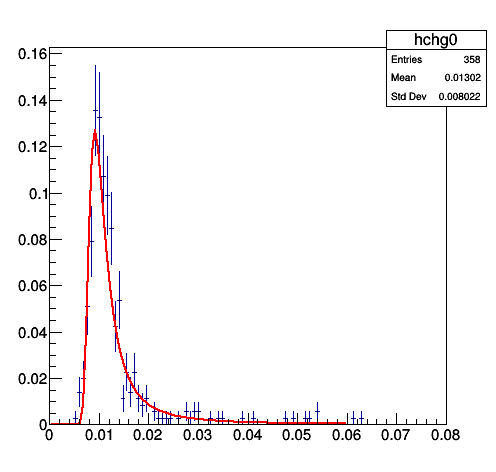

In [29]:
flandau.SetParameters(0.1, 0.01, 0.01)

hchg.Draw()
hchg.Fit(flandau,"", "", 0,0.06)
canvas.Draw()